# Backtest Evaluation – Baseline Model (v1)

This notebook evaluates a simple 1-day long/flat strategy driven by a baseline model:

- Train Linear Regression on the first 80% of time (no shuffle)
- Predict next-day return
- Signal = 1 if prediction > 0 else 0
- Strategy return = signal * y_ret_1d

Input: `data/curated/features_daily.parquet`


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


In [3]:
df = pd.read_parquet("../data/curated/features_daily.parquet")
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

print(df.shape)
df.head()


(8229, 11)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,rvol_10,y_ret_1d
0,2015-01-16,23.497101,26.497499,26.895000,26.299999,26.757500,314053200,AAPL,-0.007800,0.329180,0.025431
1,2015-01-20,24.102325,27.180000,27.242500,26.625000,26.959999,199599600,AAPL,0.025431,0.323760,0.007605
2,2015-01-21,24.286325,27.387501,27.764999,27.067499,27.237499,194303600,AAPL,0.007605,0.324523,0.025683
3,2015-01-22,24.918148,28.100000,28.117500,27.430000,27.565001,215185600,AAPL,0.025683,0.340529,0.005147
4,2015-01-23,25.046728,28.245001,28.437500,27.882500,28.075001,185859200,AAPL,0.005147,0.285719,0.001062


In [4]:
required = {"date", "symbol", "ret_1d", "rvol_10", "y_ret_1d"}
missing = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# y_ret_1d already bakes in "tomorrow", so this is a good place to ensure no NaNs
assert df[["ret_1d", "rvol_10", "y_ret_1d"]].isna().sum().sum() == 0, "Unexpected NaNs in features"


In [5]:
FEATURES = ["ret_1d", "rvol_10"]
TARGET = "y_ret_1d"

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:].copy()

model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

test["prediction"] = model.predict(test[FEATURES])
test["signal"] = (test["prediction"] > 0).astype(int)
test["strategy_ret"] = test["signal"] * test["y_ret_1d"]

test.head()


,date,adj close,close,high,low,open,volume,symbol,ret_1d,rvol_10,y_ret_1d,prediction,signal,strategy_ret
6583,2019-05-29,252.102661,278.269989,279.359985,276.709991,278.910004,104972900,SPY,-0.006733,0.124180,0.002727,0.001358,1,0.002727
6584,2019-05-30,252.791214,279.029999,280.040009,277.809998,279.109985,62523800,SPY,0.002727,0.119701,-0.013567,0.000536,1,-0.013567
6585,2019-05-31,249.384811,275.269989,277.119995,275.239990,276.200012,86862800,SPY,-0.013567,0.113670,-0.002546,0.001944,1,-0.002546
6586,2019-06-03,248.750610,274.570007,276.549988,273.089996,275.309998,96428000,SPY,-0.002546,0.113381,0.021474,0.000990,1,0.021474
6587,2019-06-04,254.150131,280.529999,280.679993,276.619995,277.119995,77231900,SPY,0.021474,0.169278,0.008625,-0.001061,0,0.000000


In [6]:
daily = (
    test.groupby("date", as_index=False)["strategy_ret"]
    .mean()
    .rename(columns={"strategy_ret": "portfolio_ret"})
)

daily["cum_log_ret"] = daily["portfolio_ret"].cumsum()
daily["equity"] = np.exp(daily["cum_log_ret"])  # start at 1.0

daily.head()


,date,portfolio_ret,cum_log_ret,equity
0,2019-05-29,0.002727,0.002727,1.002731
1,2019-05-30,-0.013567,-0.010839,0.989219
2,2019-05-31,-0.002546,-0.013386,0.986704
3,2019-06-03,0.021474,0.008089,1.008122
4,2019-06-04,0.000000,0.008089,1.008122


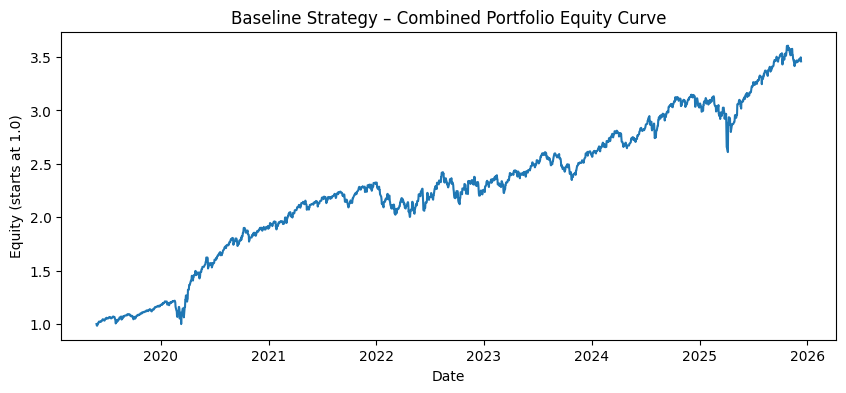

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["equity"])
plt.title("Baseline Strategy – Combined Portfolio Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.show()


In [8]:
# Basic metrics
total_log_return = daily["portfolio_ret"].sum()
total_return = daily["equity"].iloc[-1] - 1

avg_daily = daily["portfolio_ret"].mean()
std_daily = daily["portfolio_ret"].std()

# Sharpe-ish (no risk-free), annualized
sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan

# Hit rate (how often portfolio return > 0)
hit_rate = (daily["portfolio_ret"] > 0).mean()

print(f"Total log return: {total_log_return:.6f}")
print(f"Total return:     {total_return:.2%}")
print(f"Avg daily return: {avg_daily:.6e}")
print(f"Daily stdev:      {std_daily:.6e}")
print(f"Sharpe (approx):  {sharpe:.3f}")
print(f"Hit rate:         {hit_rate:.2%}")


Total log return: 1.241084
Total return:     245.94%
Avg daily return: 7.539999e-04
Daily stdev:      1.122650e-02
Sharpe (approx):  1.066
Hit rate:         46.11%


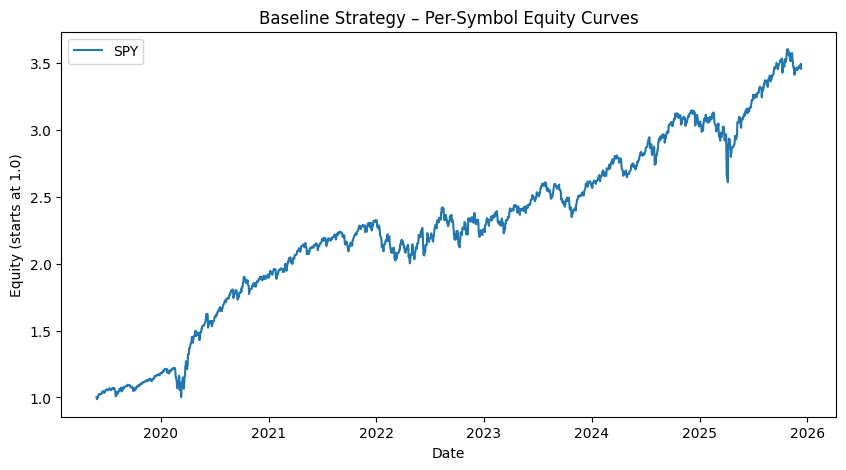

In [9]:
sym_daily = (
    test.groupby(["symbol", "date"], as_index=False)["strategy_ret"]
    .sum()
    .rename(columns={"strategy_ret": "ret"})
)

sym_daily["cum_log_ret"] = sym_daily.groupby("symbol")["ret"].cumsum()
sym_daily["equity"] = np.exp(sym_daily["cum_log_ret"])

plt.figure(figsize=(10, 5))
for sym in sym_daily["symbol"].unique():
    sub = sym_daily[sym_daily["symbol"] == sym]
    plt.plot(sub["date"], sub["equity"], label=sym)

plt.title("Baseline Strategy – Per-Symbol Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.legend()
plt.show()
